In [0]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import LeakyReLU, Dropout
from tensorflow.keras.layers import BatchNormalization

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def dataset_olivetti_faces():
    oli=np.load('/content/drive/My Drive/Colab Notebooks/olivetti_faces.npy')
    res = [cv2.resize(o, dsize=(28,28), interpolation=cv2.INTER_CUBIC) for o in oli]
    res=np.array(res)
    res=res.reshape(-1,28,28,1).astype(np.float32)
    return res

In [0]:
def discriminator(input_shape):
    D = Sequential()
    depth = 64
    dropout = 0.4

    D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,\
        padding='same'))
    D.add(LeakyReLU(alpha=0.2))
    D.add(Dropout(dropout))

    D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
    D.add(LeakyReLU(alpha=0.2))
    D.add(Dropout(dropout))

    D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
    D.add(LeakyReLU(alpha=0.2))
    D.add(Dropout(dropout))

    D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
    D.add(LeakyReLU(alpha=0.2))
    D.add(Dropout(dropout))

    # Out: 1-dim probability
    D.add(Flatten())
    D.add(Dense(1))
    D.add(Activation('sigmoid'))
    print("Discriminator: input shape:",input_shape)
    D.summary()
    return D

def generator(img_shape):
    G = Sequential()
    dropout = 0.4
    depth = 64+64+64+64
    dim = 7
    # In: 100
    # Out: dim x dim x depth
    G.add(Dense(dim*dim*depth, input_dim=100))
    G.add(BatchNormalization(momentum=0.9))
    G.add(Activation('relu'))
    G.add(Reshape((dim, dim, depth)))
    G.add(Dropout(dropout))

    # In: dim x dim x depth
    # Out: 2*dim x 2*dim x depth/2
    G.add(UpSampling2D())
    G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
    G.add(BatchNormalization(momentum=0.9))
    G.add(Activation('relu'))

    G.add(UpSampling2D())
    G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
    G.add(BatchNormalization(momentum=0.9))
    G.add(Activation('relu'))

    G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
    G.add(BatchNormalization(momentum=0.9))
    G.add(Activation('relu'))

    # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
    G.add(Conv2DTranspose(img_shape[2], 5, padding='same'))
    G.add(Activation('sigmoid'))
    print("Generator")
    G.summary()
    return G

In [26]:
image_shape=(28,28,1)

D=discriminator(image_shape)
print("X"*60)
G=generator(image_shape)

Discriminator: input shape: (28, 28, 1)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_10 (Con

In [0]:
from tensorflow.keras.optimizers import Adam, RMSprop

class DCGAN(object):
    def __init__(self, image_shape,generator,discriminator):

        self.img_shape = image_shape
        self.D = discriminator   # discriminator
        self.G = generator   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.D)
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        self.AM = Sequential()
        self.AM.add(self.G)
        self.AM.add(self.D)
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.AM

In [0]:
class faces_GAN(object):
    def __init__(self,image_shape,generator,discriminator,dataset,caption):
        self.image_shape=image_shape
        self.caption=caption
        self.x_train=dataset
        
        self.DCGAN = DCGAN(self.image_shape,generator,discriminator)
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.G

    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        d_history=[]
        a_history=[]
        t_history=[]
        print_range=300
        for i in range(train_steps):
            images_train = self.x_train[np.random.randint(0, self.x_train.shape[0], size=batch_size)]
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = self.generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = self.discriminator.train_on_batch(x, y)

            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            a_history.append(a_loss[0])  
            d_history.append(d_loss[0])
            t_history.append(i)
            
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, samples=noise_input.shape[0],\
                        noise=noise_input, step=(i+1))
                    
                    if len(d_history)>print_range+5:
                        d_h=d_history[-print_range:]
                        a_h=a_history[-print_range:]
                        t_h=t_history[-print_range:]
                    else:
                        d_h=d_history
                        a_h=a_history
                        t_h=t_history
                        
                    clear_output()
                    plt.plot(t_h,d_h)
                    plt.plot(t_h,a_h)
                    plt.legend(['Discriminator loss','Adversarial loss'])
                    plt.show()

    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        filename = self.caption+'.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = self.caption+"_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            #image = np.reshape(image, [self.img_rows, self.img_cols,3])
            if image.shape[2]==1:
                # gray scale pics
                plt.imshow(image[:,:,0],cmap='gray')
            else:
                plt.imshow(image)
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()

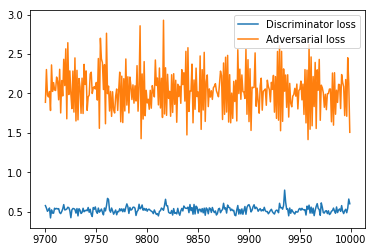

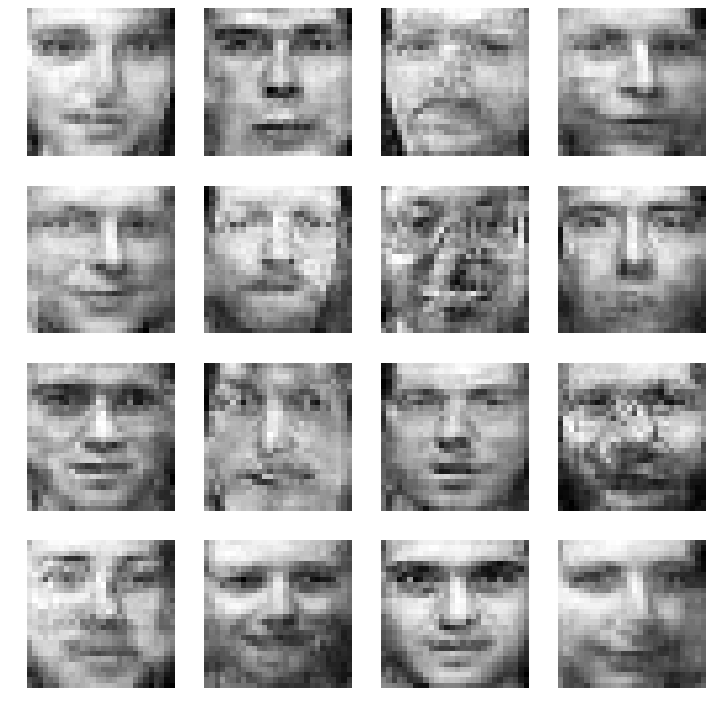

CPU times: user 21min 19s, sys: 11min 23s, total: 32min 42s
Wall time: 38min 22s


In [29]:
%%time
mygan=faces_GAN(image_shape,G,D,dataset_olivetti_faces(),"olivetti_faces")
mygan.plot_images(fake=False, save2file=True)
mygan.train(train_steps=10000, batch_size=256, save_interval=200)
mygan.plot_images(fake=True)
